In [1]:
import os
cwd = os.getcwd()
from PIL import ImageFile
import urllib2 as ul
import requests
import csv

ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io, transform,img_as_float
from skimage.io import imread
from skimage.transform import rescale, resize
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from sklearn.metrics import label_ranking_average_precision_score
import time


%matplotlib inline

## Get data

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f" -O dataset && rm -rf /tmp/cookies.txt


--2019-04-22 22:17:37--  https://docs.google.com/uc?export=download&confirm=eLjI&id=1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f
Resolving docs.google.com (docs.google.com)... 172.217.30.206, 2800:3f0:4005:403::200e
Connecting to docs.google.com (docs.google.com)|172.217.30.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rbol4csn9q6es6hbjpc4c135l8961eq/1555984800000/14149372039831478929/*/1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f?e=download [following]
--2019-04-22 22:17:37--  https://doc-0s-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rbol4csn9q6es6hbjpc4c135l8961eq/1555984800000/14149372039831478929/*/1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f?e=download
Resolving doc-0s-94-docs.googleusercontent.com (doc-0s-94-docs.googleusercontent.com)... 216.58.222.225, 2800:3f0:4005:402::2001
Connecting to doc-0s-94-docs.googleusercontent.com (doc-0s-94

In [3]:
!tar -zxvf dataset

dataset/
dataset/im_4 99.png.npy
dataset/im_4 48.png.npy
dataset/im_2 118.png.npy
dataset/im_3 55.png.npy
dataset/im_4 36.png.npy
dataset/im_4 66.png.npy
dataset/im_1 115.png.npy
dataset/im_2 20.png.npy
dataset/im_2 78.png.npy
dataset/im_3 68.png.npy
dataset/im_3 72.png.npy
dataset/im_1 60.png.npy
dataset/im_3 42.png.npy
dataset/im_2 88.png.npy
dataset/im_2 103.png.npy
dataset/im_3 59.png.npy
dataset/im_2 99.png.npy
dataset/im_4 9.png.npy
dataset/im_2 60.png.npy
dataset/im_1 41.png.npy
dataset/im_4 81.png.npy
dataset/im_1 105.png.npy
dataset/im_2 79.png.npy
dataset/im_3 96.png.npy
dataset/im_4 33.png.npy
dataset/im_3 90.png.npy
dataset/im_2 91.png.npy
dataset/im_3 73.png.npy
dataset/im_4 49.png.npy
dataset/im_2 75.png.npy
dataset/im_2 22.png.npy
dataset/im_3 67.png.npy
dataset/im_4 5.png.npy
dataset/im_3 107.png.npy
dataset/im_1 83.png.npy
dataset/im_3 52.png.npy
dataset/im_2 18.png.npy
dataset/im_2 62.png.npy
dataset/im_1 46.png.npy
dataset/im_3.png.npy
dataset/im_2 47.png.npy
dataset

dataset/im_3 116.png.npy
dataset/im_2 59.png.npy
dataset/im_3 14.png.npy
dataset/im_1 49.png.npy
dataset/im_2 25.png.npy
dataset/im_2 58.png.npy
dataset/im_4 12.png.npy
dataset/im_4 3.png.npy
dataset/im_1 79.png.npy
dataset/im_3 12.png.npy
dataset/im_2 55.png.npy
dataset/im_3 124.png.npy
dataset/im_1 39.png.npy
dataset/im_1 65.png.npy
dataset/im_4 7.png.npy
dataset/im_3 9.png.npy
dataset/im_1 118.png.npy
dataset/.ipynb_checkpoints/
dataset/im_4 17.png.npy
dataset/im_1 56.png.npy
dataset/im_3 56.png.npy
dataset/im_4 38.png.npy
dataset/im_3 16.png.npy
dataset/im_4 63.png.npy
dataset/im_3 81.png.npy
dataset/im_3 69.png.npy
dataset/im_3 89.png.npy
dataset/im_1 75.png.npy
dataset/im_1 16.png.npy
dataset/im_3 15.png.npy
dataset/im_1 58.png.npy
dataset/im_3 113.png.npy
dataset/im_4 120.png.npy
dataset/im_3 34.png.npy
dataset/im_3 49.png.npy
dataset/im_1 123.png.npy
dataset/im_4 62.png.npy
dataset/im_2 123.png.npy
dataset/im_4 41.png.npy
dataset/im_4 124.png.npy
dataset/im_3 85.png.npy
dataset

In [10]:
def get_data(h=400,w=400,limit=500):
    cwd = os.getcwd()
    data = []
    folder = cwd + "/dataset/"
    img_ids = next(os.walk(folder))[2]
    img_ids = img_ids[0:limit]
    for n,id_ in enumerate(img_ids):
        img = np.load(folder+id_)
        
        if n < 4:
            plt.imshow(img)
            plt.show()
            
        img = resize(img, (h,w))
        data.append(img)
       
    data = np.array(data)
    return data

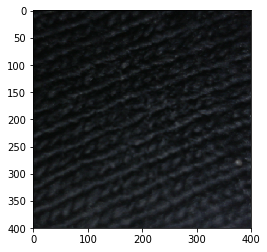

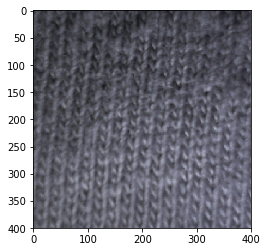

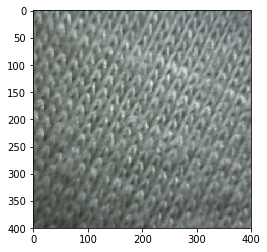

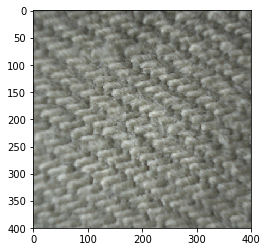

(500, 28, 28, 3)


In [11]:
limit = 500
data_np = get_data(h=28,w=28,limit=limit)
print data_np.shape

In [12]:
n_img, img_h, img_w, n_channels = data_np.shape[0],data_np.shape[1], data_np.shape[2], data_np.shape[3]
print n_img, img_h, img_w, n_channels

500 28 28 3


In [ ]:
aux = 0
while(aux < 4):
    pos = np.random.randint(0, limit)
    plt.imshow(data_np[pos])
    plt.show()
    aux += 1
   

In [13]:
shape_data = len(data_np)
shape_img = data_np.shape

print'Shape images', shape_img

Shape images (500, 28, 28, 3)


In [14]:
print np.amax(data_np)   
print data_np.dtype


1.0
float64


## Split data

In [15]:
x_train, x_test = train_test_split(data_np, test_size=0.30, random_state=42)


In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

In [17]:
print x_train.dtype

float32


In [18]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
#x_train_norm_r = np.reshape(x_train_norm, (len(x_train_norm), 28, 28, 3))  # adapt this if using `channels_first` image data format
#x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


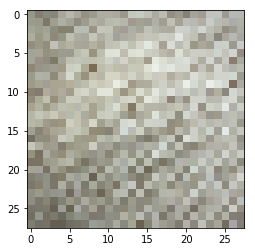

In [20]:
plt.imshow(x_train[1])

## Create noisy


In [22]:
def create_noisy(x_train,  img_h, img_w , n_channels,noise_factor=0.5):
   
    x_train_noisy = x_train.copy()
    x_train_noisy = np.array(x_train_noisy)
    n_xtrain = x_train_noisy.shape[0]
    print x_train_noisy.shape
   
    for i in range(0,n_xtrain):
        img = x_train_noisy[i]

        w = np.random.randint(0,img_h-img_h*0.60)
        h=np.random.randint(0,img_h-img_h*0.70)
        bx,by = np.random.randint(img_w-w), np.random.randint(img_h-h)
        value = img[by:by+h,bx:bx+w,:]  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(h,w,n_channels)) 
        img[by:by+h,bx:bx+w,:] = value
        img = np.clip(img, 0., 1.)
    
    return x_train_noisy

   

In [23]:
x_train_noisy = create_noisy(x_train, img_h, img_w, n_channels )
x_test_noisy = create_noisy(x_test, img_h, img_w, n_channels )

(350, 28, 28, 3)
(150, 28, 28, 3)


In [24]:
print type(x_train_noisy)

<type 'numpy.ndarray'>


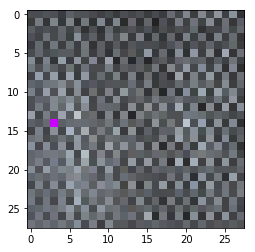

In [25]:
plt.imshow(x_train_noisy[4])

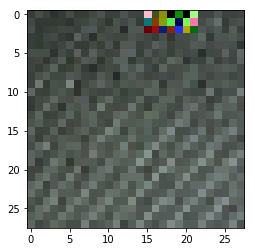

In [26]:
plt.imshow(x_test_noisy[12])

In [27]:
def train_model():
    input_img = Input(shape=(img_h, img_w, n_channels))  # adapt this if using `channels_first` image data format
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                    epochs=1,
                    batch_size=5,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    )
    #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]

    autoencoder.save('modelfabric.h5')

    return autoencoder


In [28]:
autoencoder = train_model()

Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 6s 17ms/step - loss: 0.6451 - val_loss: 0.5577


In [29]:
print (x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2])

(150, 28, 28)


In [30]:
def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2],3))
    test_img = x_test_noisy[0]
   # plt.figure(figsize=(4,2))
    plt.figure(figsize=(20,5))
    plt.subplot(311)
    plt.imshow(test_img.reshape(28,28,3))
    plt.axis("off")
    #resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    #plt.figure(figsize=(4,2))
    R= test_img[0]-denoised_images[0] 
    plt.subplot(312)
    plt.imshow( output.reshape(28,28,3))
    plt.axis("off")
    
    plt.subplot(313)
    plt.imshow( R.reshape(28,28,3))
    plt.axis("off")
    
    #resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)

In [33]:
def plot_denoised_images_2():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2],3))
    test_img = x_test_noisy[0]
   # plt.figure(figsize=(4,2))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.imshow(test_img.reshape(28,28,3), cmap=plt.cm.Greys_r)
    plt.title('con defecto')
    plt.axis("off")
    #resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    #plt.figure(figsize=(4,2))
    R= abs(output-test_img)
  
    plt.subplot(222)
    plt.imshow( output.reshape(28,28,3), cmap=plt.cm.Greys_r)
    plt.title('sin defecto')
    plt.axis("off")
    
    plt.subplot(223)
    plt.imshow( R.reshape(28,28,3), cmap=plt.cm.Greys_r)
    plt.title('defecto')
    plt.axis("off")
    
    print np.shape(R)
    R=np.array(R*255, np.dtype('uint8'))
    ret, thresh = cv2.threshold ( R, 127,255,0)
    im2, contornos, jerarquia = cv2.findContours (thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   #for c in contornos:
    #   if cv2.contourArea(c) >= 5:
     #      posicion_x,posicion_y,ancho,alto = cv2.boundingRect(c) #Guardamos las dimensiones de la Bounding Box
      #     cv2.rectangle( test_img,(posicion_x,posicion_y),(posicion_x+ancho,posicion_y+alto),(255,0,0),2) #Dibujamos la bounding box sobre diff1
    cv2.drawContours(test_img,contornos, -1, (0,255,0), 3)
    plt.subplot(224)
    plt.imshow(  test_img.reshape(28,28,3))
    plt.title('defecto')
    plt.axis("off")
    #contours,_ = cv2.findContours( R,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #imagen_gris = cv2.cvtColor( R, cv2.COLOR_BGR2GRAY)
    #resized_outpu  = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)

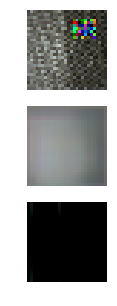

In [31]:
plot_denoised_images()

(28, 28, 3)


error: /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours_Impl


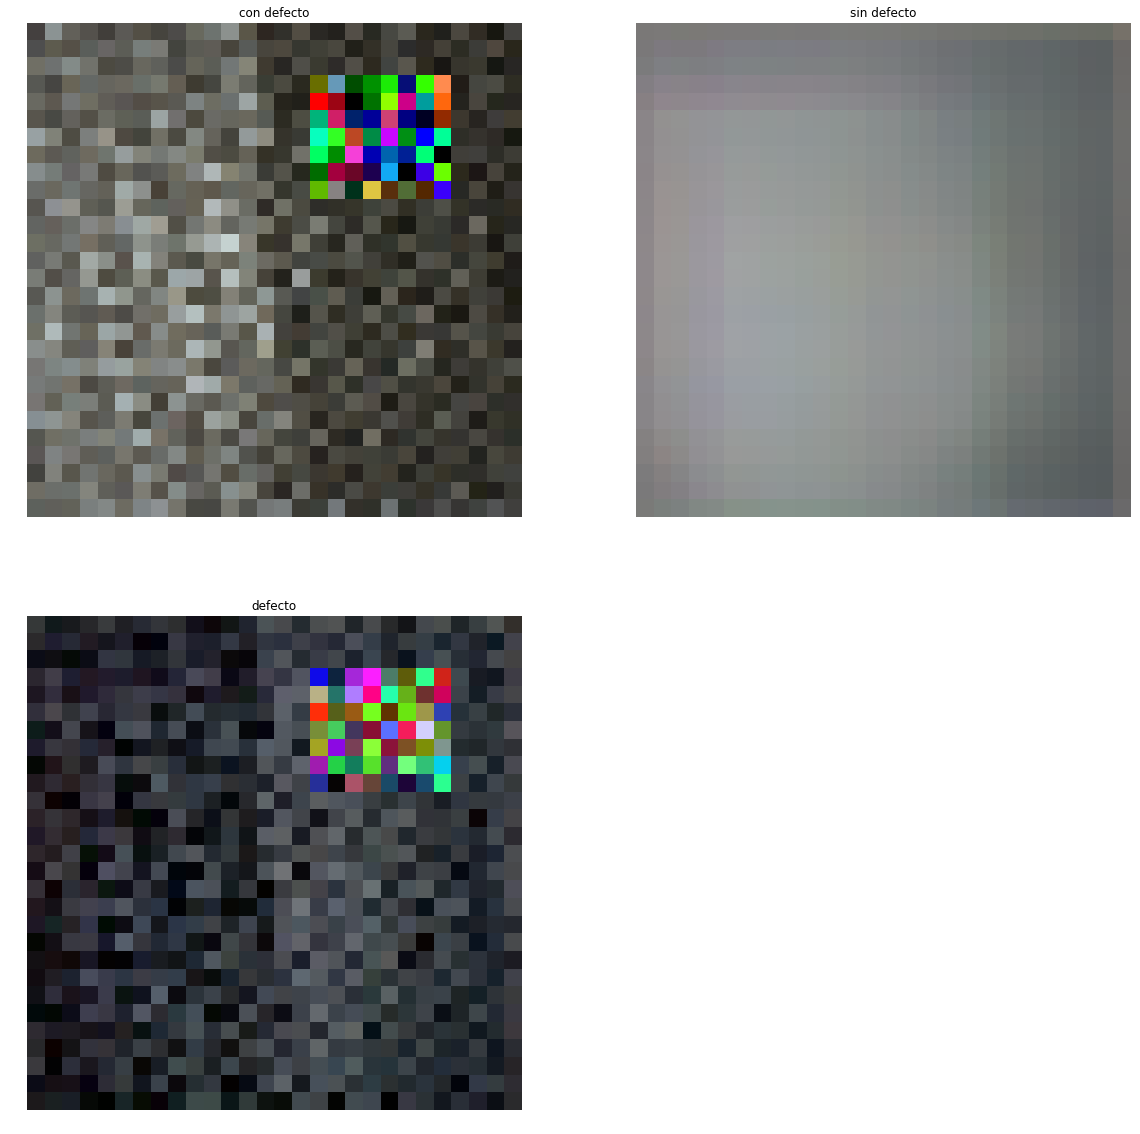

In [34]:
plot_denoised_images_2()